# Python Porfotlios

La idea de este notebook es explorar el armado de distintos portfolios y su comparación entre ellos.

[1. Carga de Librería y configuración del notebook](#bullet-1)

[2. Cargar y manipular los datos de las acciones a utilizar](#bullet-2)



####Portfolios

- [Equal Weighted Portfolio](#bullet-p0)
- [Random Weighted Portfolio](#bullet-p1)
- [Low Volatility Portfolio (Efficient Frontier)](#bullet-p2)
- [Max Sharpe Portfolio (Efficient Frontier)](#bullet-p3)
- [GoldenCross Equal Weighted Porfolio](#bullet-p4)
- [Low Volatility Portfolio con Rebalanceo cada 12 meses (Efficient Frontier)](#bullet-p5)
- [Max Sharpe Portfolio con Rebalanceo cada 12 meses (Efficient Frontier)](#bullet-p6)
- [Max Sharpe & above RSI 50 & HullMA 252 Portfolio](#bullet-p7)
- [Max Sharpe & above RSI 50 & HullMA 252 Portfolio con rebalanceo cada 12 meses](#bullet-p8)
- [Weinstein style portfolio](#bullet-p9)
- [Long/Short Alpha Jensen Portfolio](#bullet-p10)

[Comparación de resultados](#comparacion-resultados)

-

## Cargar de librearías y configuración del notebook <a class="anchor" id="bullet-1"></a>

In [38]:
import pandas as pd
import numpy as np
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import talib as ta
import pyfolio as pf
from datetime import datetime as dt 
from IPython.core.interactiveshell import InteractiveShell
import warnings
#InteractiveShell.ast_node_interactivity = "all"

In [39]:
%matplotlib inline
pd.set_option('float_format', '{:f}'.format)
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_rows = 9999
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['lines.linewidth'] = 2
warnings.filterwarnings('ignore')

## Cargar y manipular los datos <a class="anchor" id="bullet-2"></a>

En primera instancia cargamos los precios de cierre ajustados, de la gran mayoria de las acciones que componen al SP500 al 2020. Descargados de Yahoo (con la librería, fix yahoo finance)

En segunda instancia cargamos los datos del indice SP500, para utilizar como referencia.

In [3]:
data = pd.read_pickle('sp500.pkl')

In [4]:
data.head()

,MMM,ABT,ABMD,ATVI,ADBE,AMD,AES,AMG,AFL,APD,...,WELL,WDC,WY,WHR,WMB,XEL,XRX,XLNX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
1998-12-31,19.055,8.930,4.906,0.836,5.789,14.500,18.677,19.389,5.179,21.721,...,6.280,11.981,26.111,32.788,11.429,10.714,127.383,11.696,5.941,46.087
1999-01-04,19.993,8.885,4.438,0.817,6.184,14.000,19.293,19.105,5.194,21.178,...,6.250,11.981,25.629,33.121,11.063,10.594,127.113,11.976,5.703,44.563
1999-01-05,20.110,8.896,4.625,0.813,6.052,13.844,19.219,19.146,5.031,21.279,...,6.447,13.175,25.854,33.158,10.948,10.618,129.542,12.481,5.815,44.425
1999-01-06,21.048,8.828,4.500,0.827,5.836,13.625,19.219,18.781,5.090,21.755,...,6.311,13.125,26.079,33.010,11.292,10.666,132.038,12.380,5.903,44.471
1999-01-07,20.562,8.714,4.375,0.822,5.959,13.719,18.726,19.186,5.046,21.212,...,6.129,14.318,26.175,32.011,11.292,10.618,131.431,12.290,5.874,44.148


In [5]:
#Eliminamos las columnas que tienen NaN values. para tener la misma información hasta determinado periodo de tiempo. 
nan_values = data.columns[data.isna().any()].tolist()

for n in nan_values:
    del data[n]
    
data.shape    

(5308, 364)

Ahora vamos a dividir el dataframe en dos partes. La primera sera la parte con la cual buscaremos información de testeo y la segundo la información para hacer el backtest

In [6]:
train = data.loc[:'2000-12-31']
test = data.loc['2000-12-31':]

In [7]:
train.tail(3)

,MMM,ABT,ABMD,ATVI,ADBE,AMD,AES,AMG,AFL,APD,...,WELL,WDC,WY,WHR,WMB,XEL,XRX,XLNX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-12-27,35.310,9.527,25.875,1.128,32.538,14.625,44.105,34.478,8.847,23.848,...,5.015,1.889,27.944,29.447,14.745,12.881,11.018,34.615,3.829,47.034
2000-12-28,36.124,9.514,25.250,1.118,30.613,14.312,44.253,37.318,8.917,23.787,...,5.131,1.989,28.319,30.421,15.364,12.772,11.018,34.885,3.963,47.368
2000-12-29,35.698,9.502,24.250,1.137,28.906,13.812,43.662,35.614,8.948,23.324,...,5.015,1.939,27.638,29.720,15.221,12.744,10.192,33.134,3.911,47.654


In [8]:
test.head(3)

,MMM,ABT,ABMD,ATVI,ADBE,AMD,AES,AMG,AFL,APD,...,WELL,WDC,WY,WHR,WMB,XEL,XRX,XLNX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-02,35.310,9.441,22.500,1.052,23.221,14.375,40.804,32.572,8.630,23.004,...,4.957,1.839,27.298,29.447,14.459,12.415,11.293,31.069,3.785,45.746
2001-01-03,34.902,9.232,24.625,1.132,28.788,16.250,39.374,37.642,8.398,23.182,...,5.150,2.237,27.978,30.850,14.292,11.977,11.569,36.681,4.000,47.272
2001-01-04,35.254,8.386,22.625,1.236,26.707,16.688,39.276,37.642,8.073,23.502,...,5.150,2.585,28.829,31.356,13.482,11.127,13.497,37.579,4.007,46.318


Cargamos datos del SP500

In [9]:
spx = yf.download('^GSPC', start='2001-01-02')['Adj Close']

[*********************100%***********************]  1 of 1 downloaded


In [10]:
spx.head(3)

Date
2001-01-02   1,283.270
2001-01-03   1,347.560
2001-01-04   1,333.340
Name: Adj Close, dtype: float64

## Análisis de los datos <a class="anchor" id="data-analisis"></a>

In [11]:
train_returns = train.pct_change().dropna()

In [12]:
def get_risk_matrix(returns):
    #Calculamos la media y la desviación típica
    risk_matrix = returns.describe().T.loc[:, ["mean", "std"]]

    #Anualizamos
    risk_matrix['mean'] = risk_matrix['mean'] * 252
    risk_matrix['std'] = risk_matrix['std'] * np.sqrt(252)

    return risk_matrix

In [13]:
risk_matrix = get_risk_matrix(train_returns)

Text(0.5,1,'Risk & Return')

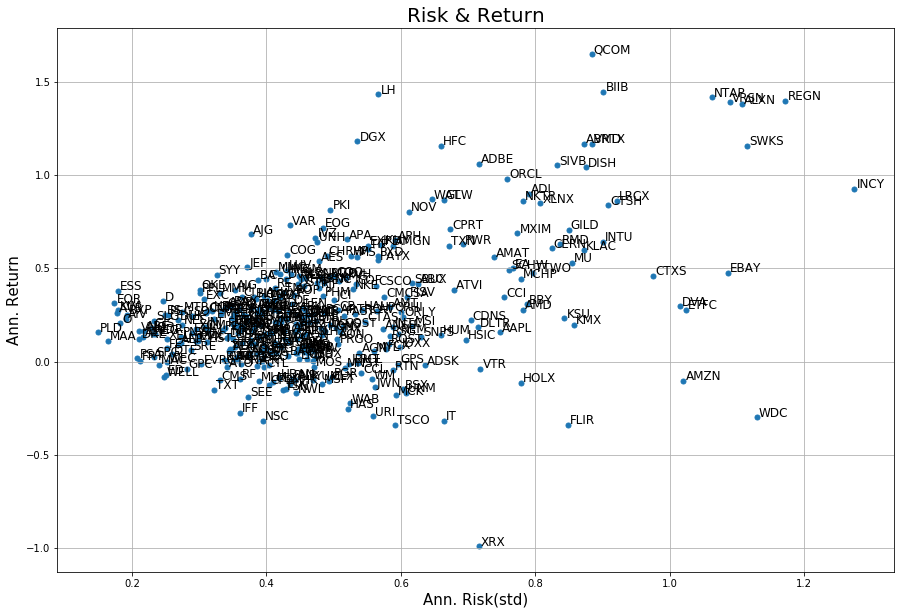

In [14]:
risk_matrix.plot.scatter(x= "std", y= "mean", figsize=(15,10), s= 25, fontsize=10, grid=True)
for name in risk_matrix.index:
    plt.annotate(name, xy=(risk_matrix.loc[name, "std"]+0.003, risk_matrix.loc[name, "mean"]+0.003), size=12)
plt.xlabel("Ann. Risk(std)", fontsize=15)
plt.ylabel("Ann. Return", fontsize=15)

plt.title("Risk & Return", fontsize=20)

## PORTFOLIOS


Creamos el DataFrame PORTFOLIOS, que obtendra los resultados de todos los portfolios que crearemos. y definimos el capital inicial por defecto, que será de 1 millon de dolares. <br><br>

In [15]:
PORTFOLIOS = pd.DataFrame(index=spx.index)


In [16]:
CAPITAL = 1000000

In [17]:
prices = test.copy()

In [18]:
#Generamos el retorno del SPX en base al Capital inicial

PORTFOLIOS['Benchmark'] = spx.div(spx.iloc[0]).mul(CAPITAL)
#PORTFOLIOS['test'] = prices.div(prices.iloc[0]).mul(CAPITAL/len(prices.columns)).sum(axis=1)

<br><br>

## Formulas


Formulas que vamos a necesitar para calcular ciertas cosas de los portfolios.


get_random_Weights calcula ponderaciones para X cantidad de acciones con suma 1.

In [19]:
def get_random_weights(n = 30):
    return np.random.dirichlet(np.ones(n),size=1)

get portfolio_value calcula a traves de unas ponderaciones el valor que se detinado a cada accion y luego devuelve la suma del portfolio y su retorno.

In [20]:
def get_portfolio_value(prices, weights, cap):
    w = np.floor(cap * weights / prices.head(1))
    w = list(w.iloc[0,:])
    port_rest = prices * w
    
    port_rest['CASH_HOLDING'] = cap - port_rest.iloc[0,:].sum()
    
    port_rest.to_csv('port.csv')
    portfolio_value = port_rest.sum(axis=1)
    return portfolio_value

In [21]:
#Efficient

In [22]:
def EfficientFrontier(returns, rf = 0, n = 100):
    
    cantidad_de_acciones = len(returns.columns)
    numero_de_portfolios = n
    all_weights = np.zeros((numero_de_portfolios, len(returns.columns)))
    return_array = np.zeros(numero_de_portfolios)
    volatility_array = np.zeros(numero_de_portfolios)
    sharpe_array = np.zeros(numero_de_portfolios)
    
    for x in range(numero_de_portfolios):
        
        weights = np.array(np.random.random(cantidad_de_acciones))
        weights = weights/np.sum(weights)
        # Save weights
        all_weights[x,:] = weights

        # Expected return
        return_array[x] = np.sum( (returns.mean() * weights * 252))

        # Expected volatility
        volatility_array[x] = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))

        # Sharpe Ratio
        sharpe_array[x] = (return_array[x] - rf) / volatility_array[x]
        
    portfolio = {'Returns':return_array, 'Volatility':volatility_array, 'Sharpe Ratio': sharpe_array,}
    
    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter,symbol in enumerate(returns.columns):
        portfolio[symbol+'_Weight'] = [Weight[counter] for Weight in all_weights]
    
    # make a nice dataframe of the extended dictionary
    df = pd.DataFrame(portfolio)
    
    return df

<br><br>

## Equal Weighted Portfolio <a class="anchor" id="bullet-p0"></a>

Equal Weighted Portfolio - Es un portfolio donde todos los activos estan ponderados de la misma manera. <br><br>



In [23]:
#calculamos la ponderación para cada acción, en este caso es la misma.
eq_weight = np.full(len(prices.columns), 1 / len(prices.columns))

#Calculamos el portfolio
PORTFOLIOS['Equal weights portfolio'] = get_portfolio_value(prices, eq_weight, CAPITAL)

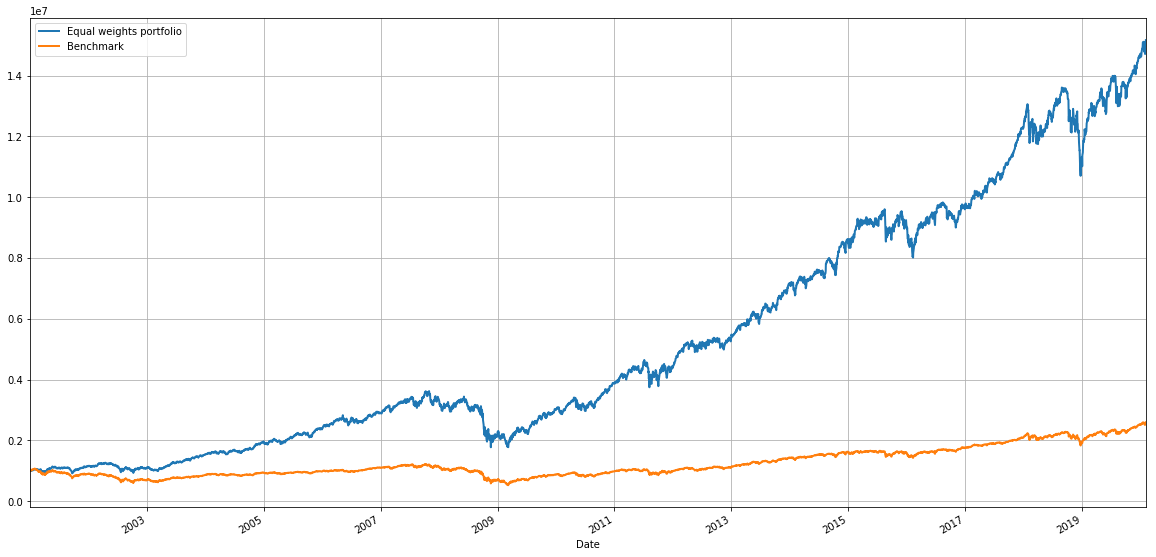

In [26]:
PORTFOLIOS[['Equal weights portfolio', 'Benchmark']].plot(grid=True)

In [27]:
PORTFOLIOS['Equal weights portfolio'].head(3)

Date
2001-01-02   1,000,000.000
2001-01-03   1,036,365.828
2001-01-04   1,020,934.067
Name: Equal weights portfolio, dtype: float64

Start date,2001-01-03
End date,2020-02-07
Total months,228
,Backtest
Annual return,15.3%
Cumulative returns,1416.8%
Annual volatility,19.4%
Sharpe ratio,0.83
Calmar ratio,0.30
Stability,0.97
Max drawdown,-51.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,50.99,2007-10-31,2008-11-20,2010-11-04,787
1,26.28,2002-04-16,2002-10-09,2003-06-11,302
2,21.34,2018-08-29,2018-12-24,2019-06-20,212
3,19.83,2001-05-21,2001-09-21,2001-12-05,143
4,19.34,2011-07-07,2011-08-08,2012-01-18,140


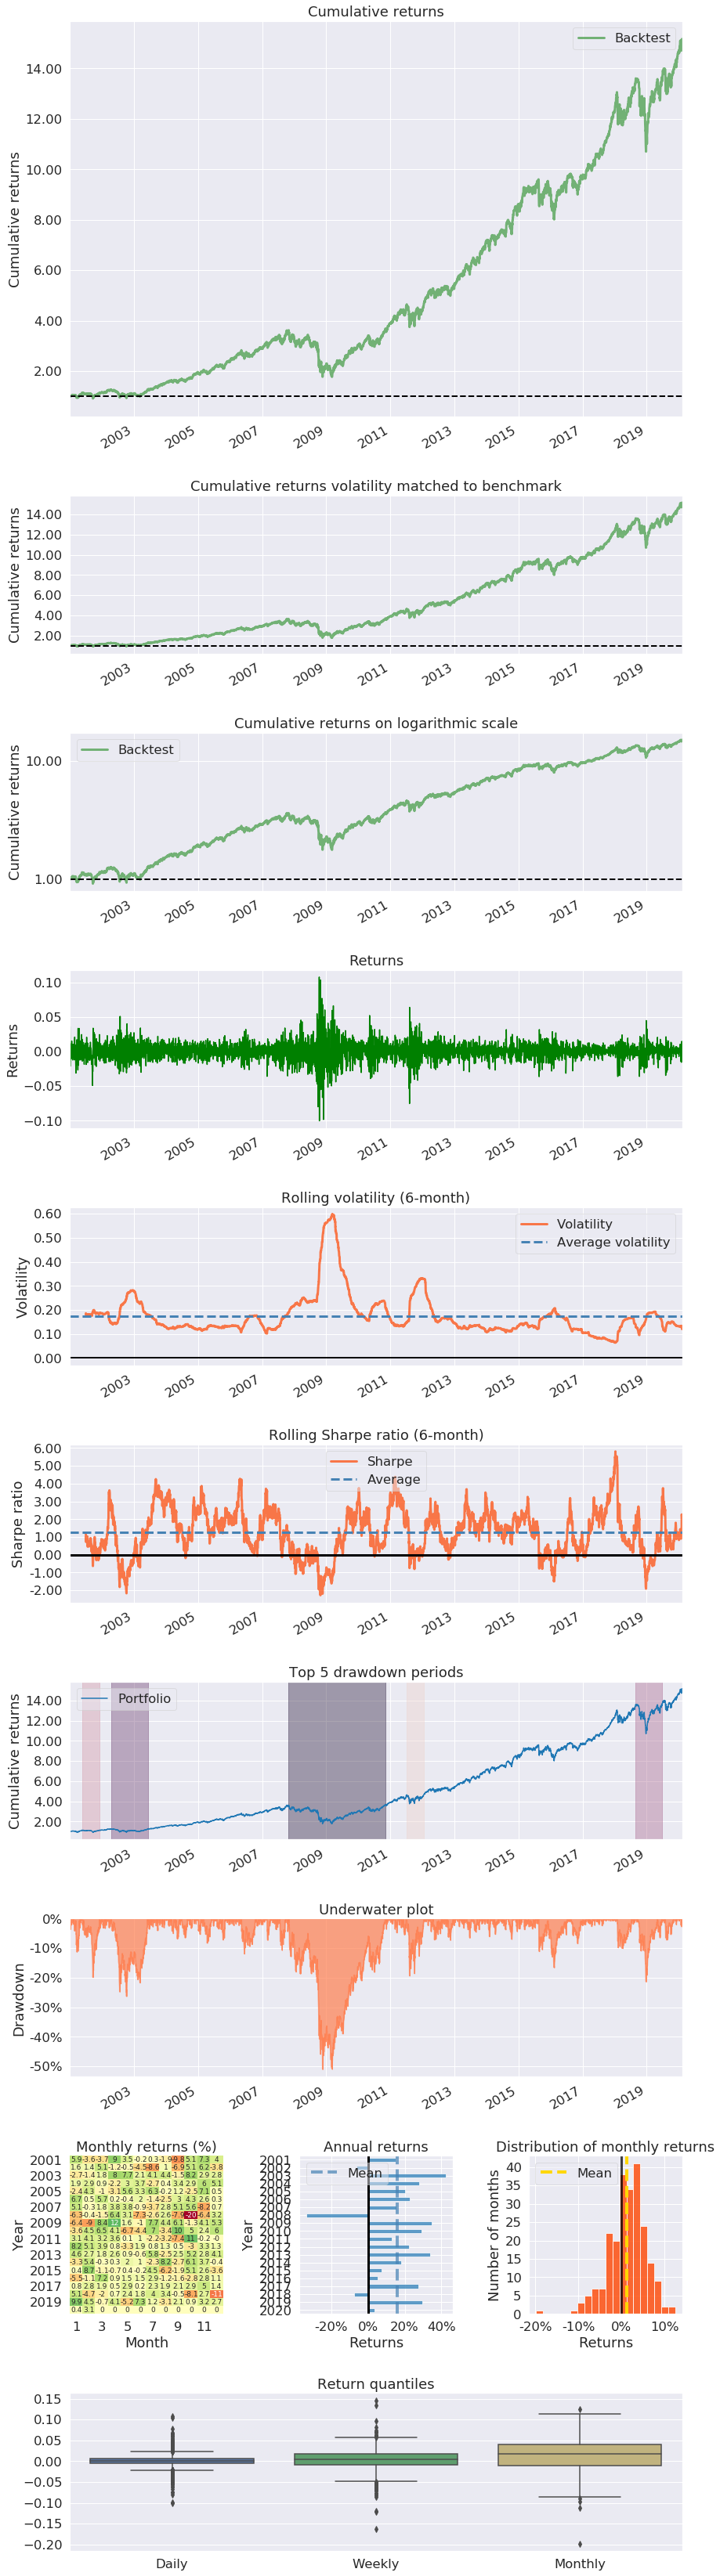

In [40]:
pf.create_returns_tear_sheet(PORTFOLIOS['Equal weights portfolio'].pct_change().dropna()) 

# Random Weighted Portfolio <a class="anchor" id="bullet-p1"></a>

En este portfolio simplemente vamos a tomar todas las acciones, y las ponderamos al azar

In [42]:
random_w = get_random_weights(len(prices.columns))

In [43]:
PORTFOLIOS['Random weights portfolio'] = get_portfolio_value(prices, random_w, CAPITAL)

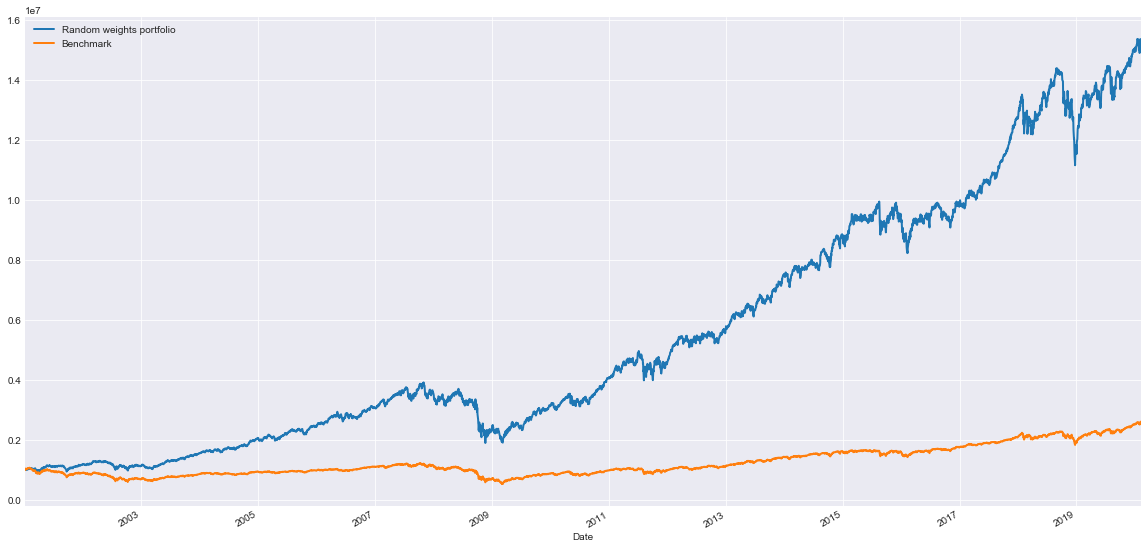

In [49]:
PORTFOLIOS[['Random weights portfolio', 'Benchmark']].plot(grid=True)

Start date,2001-01-03
End date,2020-02-07
Total months,228
,Backtest
Annual return,15.4%
Cumulative returns,1437.2%
Annual volatility,19.7%
Sharpe ratio,0.83
Calmar ratio,0.30
Stability,0.97
Max drawdown,-51.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,51.55,2007-10-31,2008-11-20,2010-12-03,808
1,25.10,2002-04-16,2002-10-09,2003-06-11,302
2,22.48,2018-08-29,2018-12-24,2019-07-12,228
3,19.67,2011-07-07,2011-08-08,2012-01-25,145
4,18.45,2001-06-05,2001-09-21,2001-12-05,132


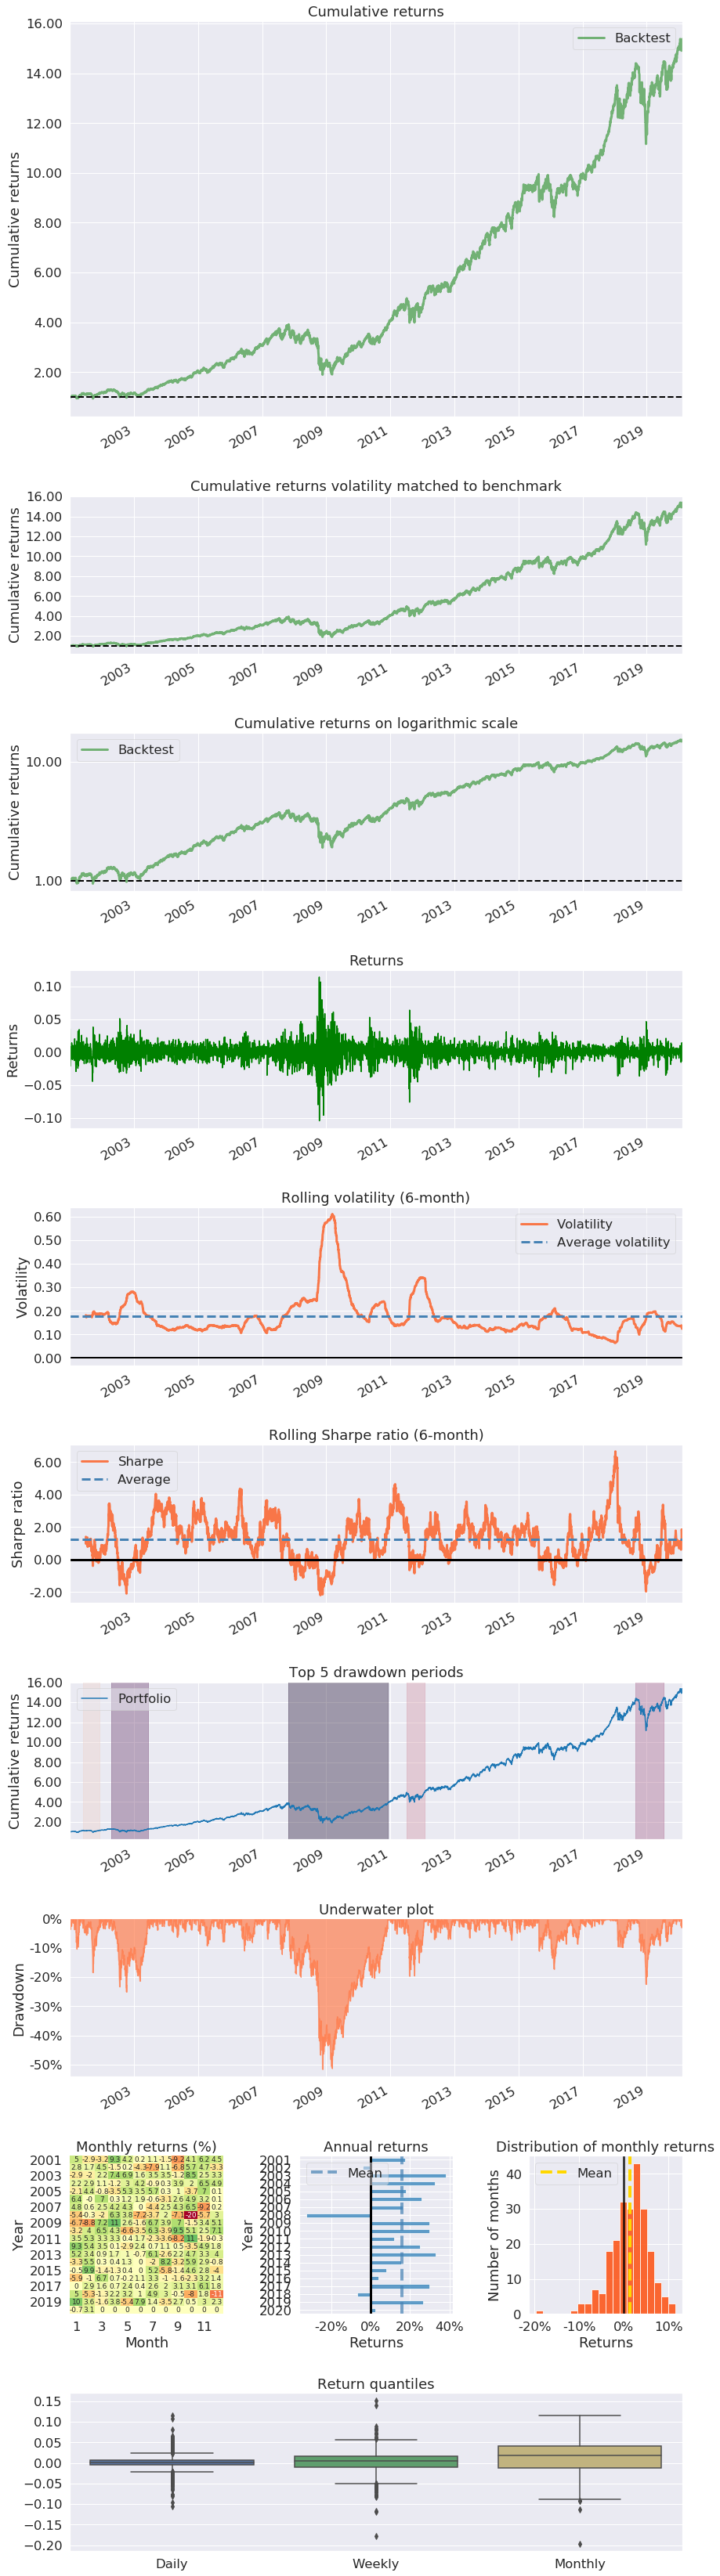

In [45]:
pf.create_returns_tear_sheet(PORTFOLIOS['Random weights portfolio'].pct_change().dropna()) 

### Armamos el Efficient Frontier para los proximos dos portfolios 

Cuando hablamos de frontera eficiente hacemos referencia al concepto de frontera de carteras eficiente, se trata del conjunto de carteras más eficiente y rentable que podemos ver que se comercializan debido a que la rentabilidad esperada es mayor con respecto a otras carteras que no lo son. Esto se mide viendo y comparando los diferentes niveles de riesgo que asumen los particulares por invertir en determinadas carteras.

In [41]:
%%time
ef = EfficientFrontier(train_returns, 0, 10000)
        

Wall time: 14min 39s


In [ ]:
#%%time
#ef = EfficientFrontier(train_returns, 0, 50)

In [46]:
ef.head()

,AAPL_Weight,ABC_Weight,ABMD_Weight,ABT_Weight,ADBE_Weight,ADI_Weight,ADM_Weight,ADP_Weight,ADSK_Weight,AEE_Weight,...,WMT_Weight,WM_Weight,WY_Weight,XEL_Weight,XLNX_Weight,XOM_Weight,XRAY_Weight,XRX_Weight,YUM_Weight,ZION_Weight
0,0.005,0.002,0.000,0.005,0.002,0.005,0.000,0.005,0.002,0.003,...,0.002,0.005,0.003,0.001,0.004,0.003,0.001,0.001,0.005,0.005
1,0.002,0.002,0.002,0.001,0.003,0.001,0.003,0.002,0.002,0.004,...,0.001,0.004,0.002,0.004,0.005,0.004,0.003,0.005,0.001,0.003
2,0.000,0.000,0.005,0.005,0.001,0.002,0.000,0.003,0.001,0.000,...,0.003,0.005,0.004,0.005,0.001,0.002,0.003,0.003,0.001,0.000
3,0.002,0.004,0.001,0.002,0.004,0.004,0.004,0.005,0.004,0.005,...,0.001,0.005,0.005,0.004,0.003,0.000,0.005,0.001,0.005,0.001
4,0.004,0.002,0.004,0.003,0.002,0.002,0.002,0.004,0.002,0.002,...,0.004,0.004,0.004,0.005,0.004,0.004,0.001,0.003,0.003,0.003


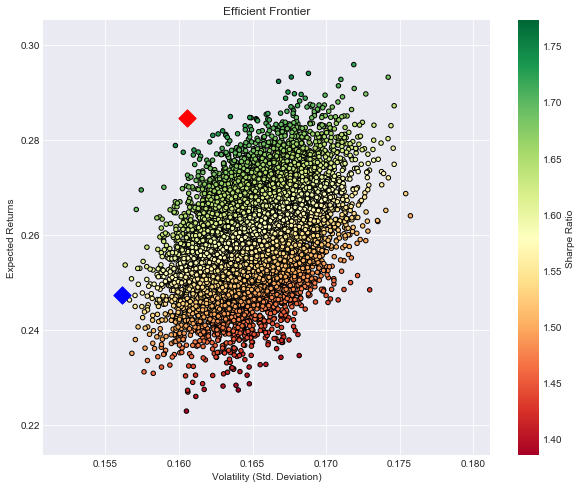

In [47]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = ef['Volatility'].min()
max_sharpe = ef['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = ef.loc[ef['Sharpe Ratio'] == max_sharpe]
volatility_port = ef.loc[ef['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
ef.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)

plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], color='r', marker='D', s=150)
plt.scatter(x=volatility_port['Volatility'], y=volatility_port['Returns'], color='b', marker='D', s=150 )

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

## Max Sharpe Ratio Portfolio (Efficient Frontier)
<a class="anchor" id="bullet-p2"></a>

$ Sharpe Ratio =\frac{(Retornos del Portfolio - Tasa Libre de Riesgo)} {(Desviación típica de los retornos del portfolio)}   $

El Sharpe Ratio fue desarrollado por el Premio Nóbel William Sharpe de la Universidad de Stanford. Mide numéricamente la relación Rentabilidad / Volatilidad Histórica (desviación standard) de un Portfolio. Se calcula dividiendo la rentabilidad de un fondo menos la tasa de interés sin riesgo entre la volatilidad o desviación standard de esa rentabilidad en el mismo periodo.

Por eso en este Portfolio, usaremos el portfolio con el mayor ratio de Sharpe sobre las acciones seleccionadas obtenidas de un resultado de 25.000 portfolios.
<br><br>


In [48]:
sharpe_portfolio_allocation = ef.loc[sharpe_portfolio.T.columns[0]]
sharpe_portfolio_allocation = sharpe_portfolio_allocation.drop(['Sharpe Ratio', 'Returns', 'Volatility'])
sharpe_portfolio_allocation = sharpe_portfolio_allocation.values
PORTFOLIOS['Maxium Sharpe portfolio (Efficiente Frontier)'] = get_portfolio_value(prices, sharpe_portfolio_allocation, CAPITAL)

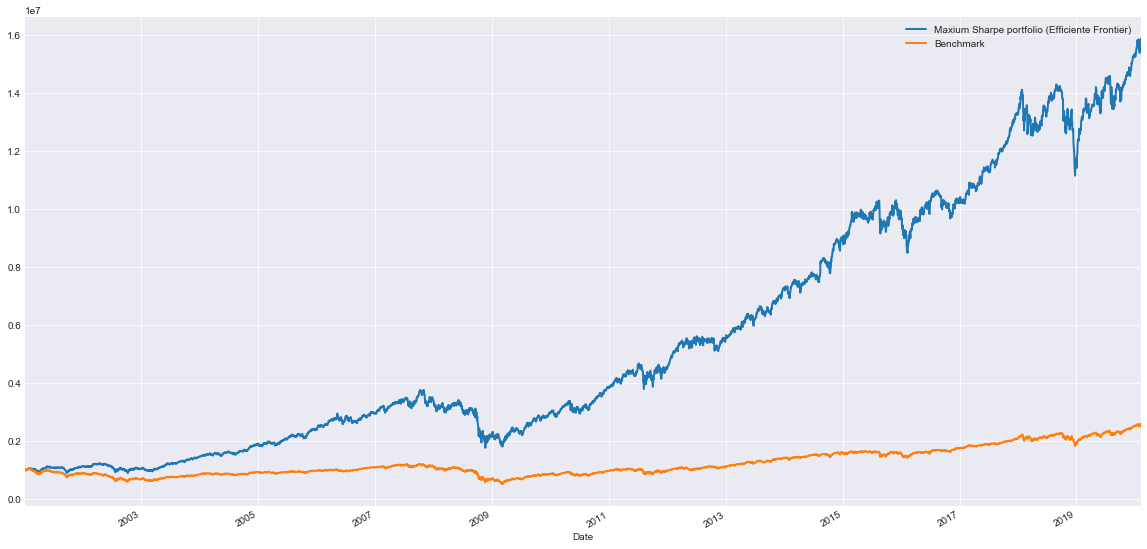

In [50]:
PORTFOLIOS[['Maxium Sharpe portfolio (Efficiente Frontier)', 'Benchmark']].plot(grid=True)


Start date,2001-01-03
End date,2020-02-07
Total months,228
,Backtest
Annual return,15.6%
Cumulative returns,1485.7%
Annual volatility,19.9%
Sharpe ratio,0.83
Calmar ratio,0.29
Stability,0.97
Max drawdown,-52.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.89,2007-10-31,2008-11-20,2010-12-07,810
1,26.69,2002-04-16,2002-10-09,2003-06-16,305
2,21.99,2018-08-29,2018-12-24,2019-07-01,219
3,20.57,2001-05-21,2001-09-21,2001-12-28,160
4,18.89,2011-07-07,2011-08-08,2012-01-12,136


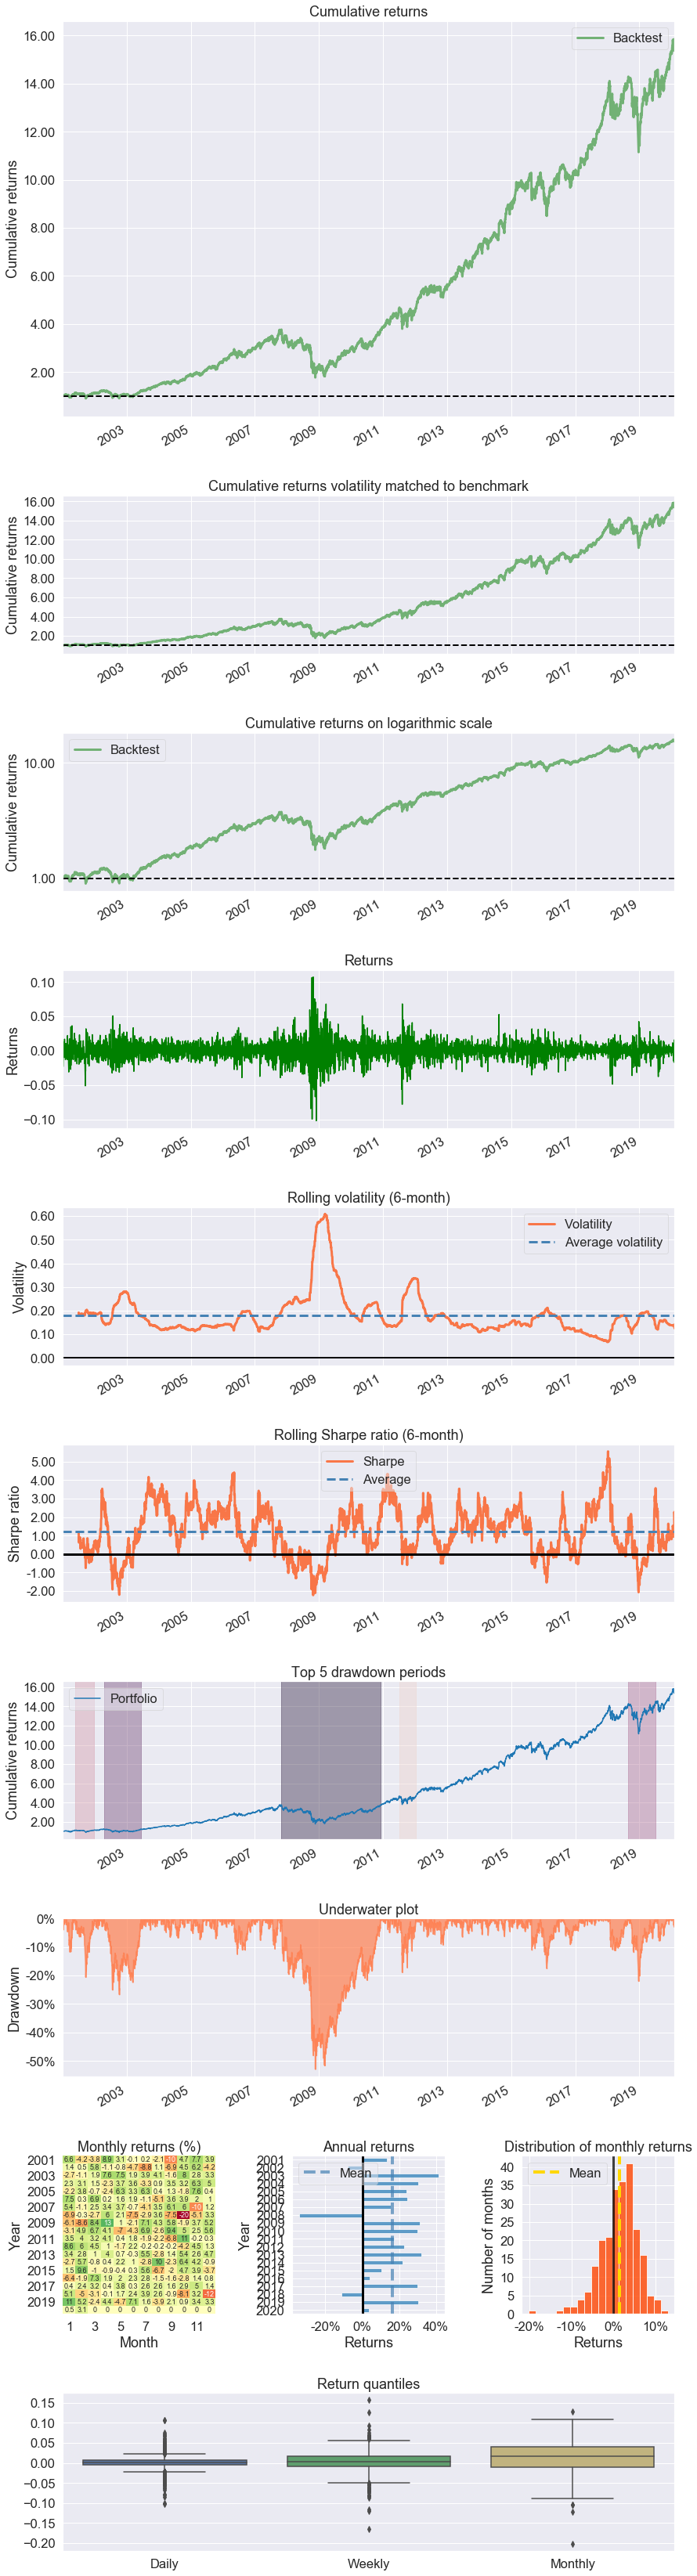

In [51]:
pf.create_returns_tear_sheet(PORTFOLIOS['Maxium Sharpe portfolio (Efficiente Frontier)'].pct_change().dropna()) 

## Low Volatility Portfolio (Efficient Frontier)
<a class="anchor" id="bullet-p3"></a>

In [52]:
min_volatility_allocation = ef.loc[volatility_port.T.columns[0]]
min_volatility_allocation = min_volatility_allocation.drop(['Sharpe Ratio', 'Returns', 'Volatility'])
min_volatility_allocation = min_volatility_allocation.values
PORTFOLIOS['minium volatility portfolio (Efficiente Frontier)'] = get_portfolio_value(prices, min_volatility_allocation, CAPITAL)

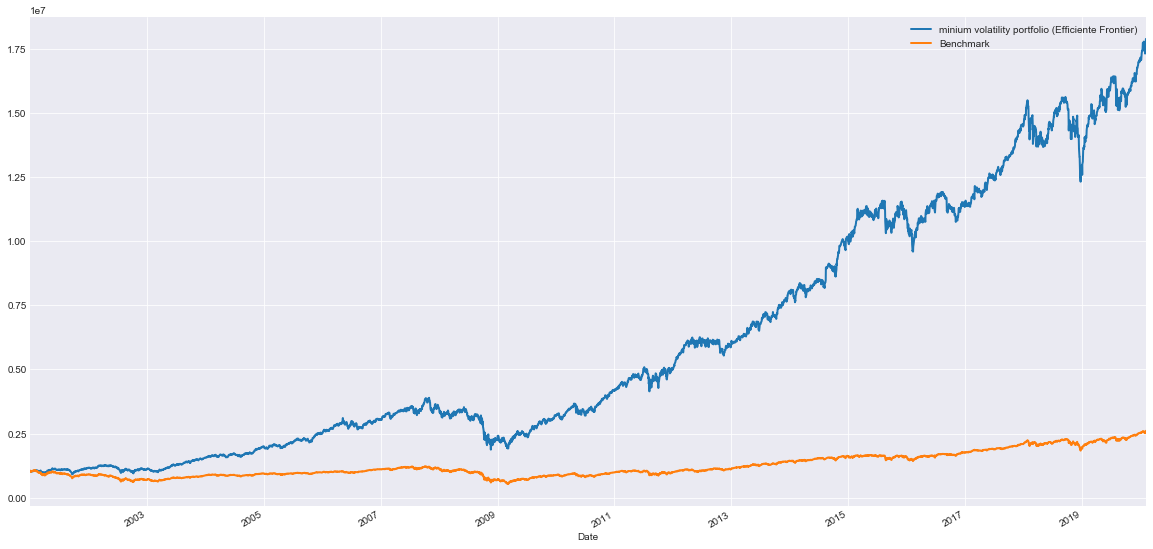

In [53]:
PORTFOLIOS[['minium volatility portfolio (Efficiente Frontier)', 'Benchmark']].plot(grid=True)


Start date,2001-01-03
End date,2020-02-07
Total months,228
,Backtest
Annual return,16.3%
Cumulative returns,1690.4%
Annual volatility,19.8%
Sharpe ratio,0.86
Calmar ratio,0.31
Stability,0.97
Max drawdown,-51.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,51.94,2007-10-31,2008-11-20,2010-11-02,785
1,25.90,2002-04-16,2002-10-09,2003-06-11,302
2,21.15,2018-09-20,2018-12-24,2019-04-26,157
3,20.51,2001-05-21,2001-09-21,2001-12-05,143
4,18.56,2011-07-07,2011-08-08,2012-01-06,132


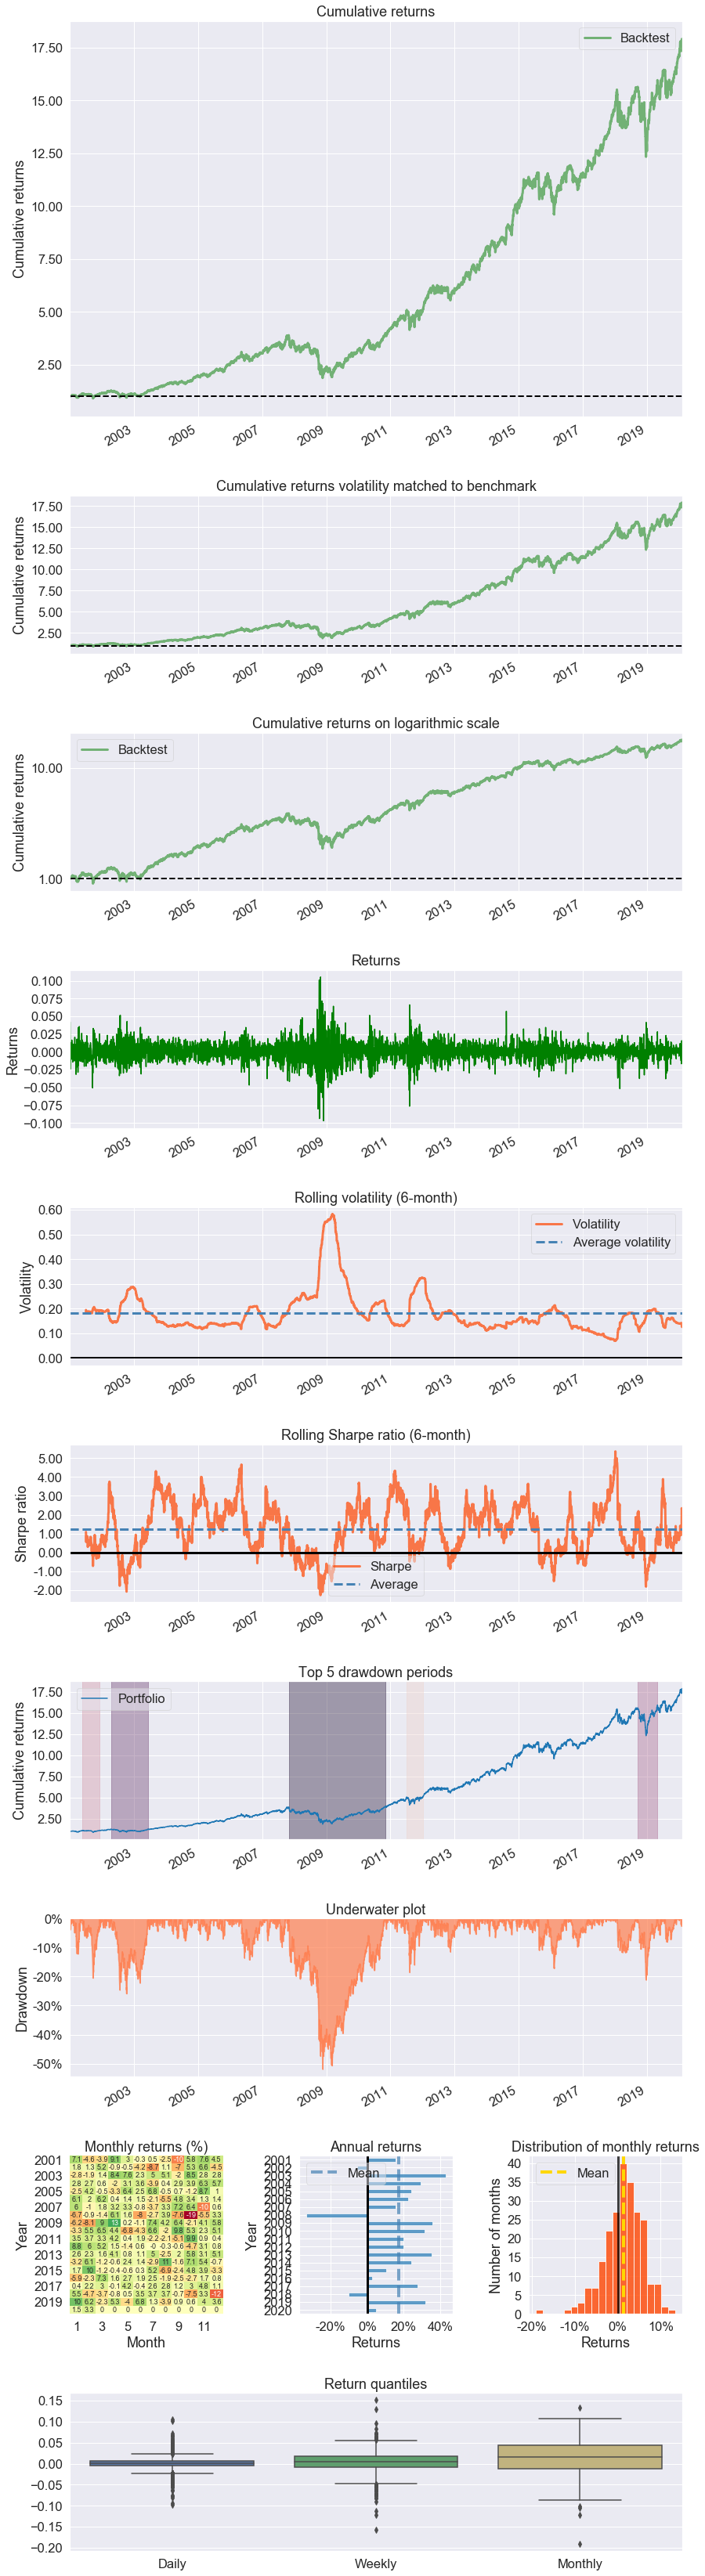

In [54]:
pf.create_returns_tear_sheet(PORTFOLIOS['minium volatility portfolio (Efficiente Frontier)'].pct_change().dropna()) 

# Golden Cross Strategy Portfolio (Eq. Weigthed)
<a class="anchor" id="bullet-p4"></a>

La idea de este portfolio es comprar las acciones cuando la media móvil de 50 días esta por encima de la media móvil de 200 dias. El famoso cruce dorado como suele encontrarse. Para no complicarnos con el rebalanceo continuo, pondremos la misma ponderación para cada acción, y cuando la media móvil de 50 periodos este por debajo de la media móvil de 200 periodos, se cerrara la posición, y ese dinero quedara en el portfolio en formato de cash (Efectivo)
<br><br>

In [55]:
def get_golden_cross(p):
    close = p.copy()
    golden_cross = pd.DataFrame(index=close.index)
    for t in close.columns:
        golden_cross[t] = np.where(ta.SMA(close[t], 50) > ta.SMA(close[t], 200), 1, 0)
    
    #Movemos un fila todo, para comprar al dia posterior. 
    gc = golden_cross.shift(1)    
    gc = gc.loc['2000-12-31':]    
    return gc

In [56]:
golden_cross_df = get_golden_cross(data)

In [57]:
positions = prices.mul(golden_cross_df)

In [58]:
s = np.multiply(eq_weight, CAPITAL)

In [59]:
stocks_qty = np.floor(s / prices.head(1))
sq = list(stocks_qty.loc['2001-01-02'])

In [60]:
porr = positions.mul(sq)

In [61]:
porr.sum(axis=1)

Date
2001-01-02      633,468.132
2001-01-03      641,818.493
2001-01-04      624,405.198
2001-01-05      633,681.556
2001-01-08      640,313.316
2001-01-09      645,812.015
2001-01-10      661,657.361
2001-01-11      662,701.188
2001-01-12      658,000.863
2001-01-16      667,129.718
2001-01-17      663,974.793
2001-01-18      664,674.645
2001-01-19      650,378.201
2001-01-22      667,840.807
2001-01-23      677,275.068
2001-01-24      681,007.993
2001-01-25      677,063.197
2001-01-26      678,487.194
2001-01-29      689,243.613
2001-01-30      686,969.653
2001-01-31      691,264.486
2001-02-01      694,624.743
2001-02-02      689,428.149
2001-02-05      709,140.140
2001-02-06      713,198.798
2001-02-07      720,987.281
2001-02-08      725,015.177
2001-02-09      725,292.491
2001-02-12      735,396.737
2001-02-13      735,821.848
2001-02-14      735,016.493
2001-02-15      742,947.289
2001-02-16      738,364.340
2001-02-20      735,886.126
2001-02-21      730,145.086
2001-02-22     

In [62]:
PORTFOLIOS['Golden Cross Strategy Portfolio'] = get_portfolio_value(positions, eq_weight, CAPITAL)

In [63]:
PORTFOLIOS['Golden Cross Strategy Portfolio']

Date
2001-01-02   1,000,000.000
2001-01-03             inf
2001-01-04             inf
2001-01-05             inf
2001-01-08             inf
2001-01-09             inf
2001-01-10             inf
2001-01-11             inf
2001-01-12             inf
2001-01-16             inf
2001-01-17             inf
2001-01-18             inf
2001-01-19             inf
2001-01-22             inf
2001-01-23             inf
2001-01-24             inf
2001-01-25             inf
2001-01-26             inf
2001-01-29             inf
2001-01-30             inf
2001-01-31             inf
2001-02-01             inf
2001-02-02             inf
2001-02-05             inf
2001-02-06             inf
2001-02-07             inf
2001-02-08             inf
2001-02-09             inf
2001-02-12             inf
2001-02-13             inf
2001-02-14             inf
2001-02-15             inf
2001-02-16             inf
2001-02-20             inf
2001-02-21             inf
2001-02-22             inf
2001-02-23             

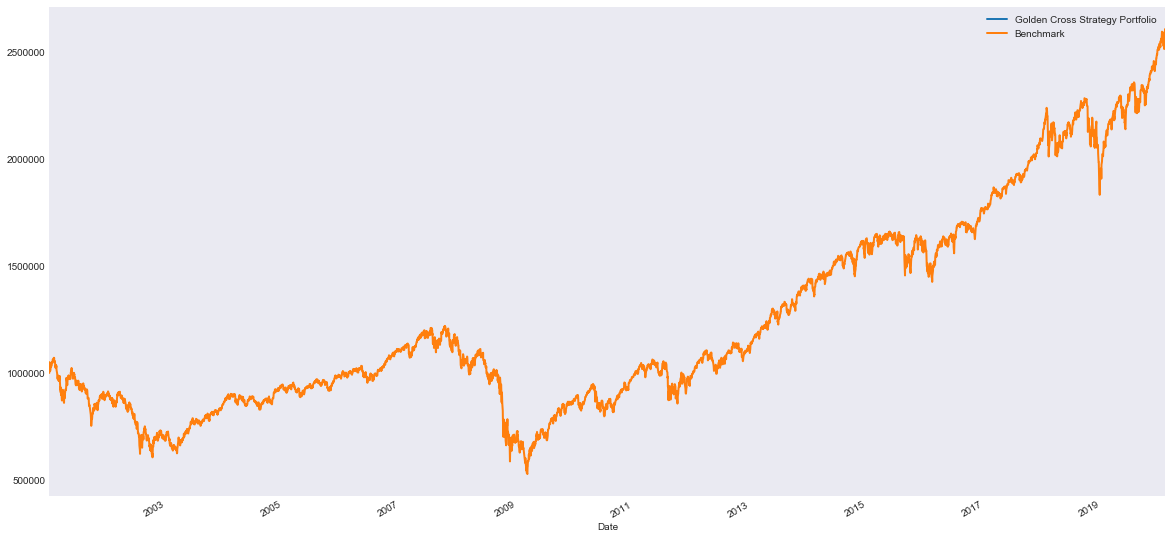

In [64]:

PORTFOLIOS[['Golden Cross Strategy Portfolio', 'Benchmark']].plot()

In [ ]:
len(eq_weight)

In [ ]:
CAPITAL / eq_weight

In [ ]:
c = 10
eww = [0.25,0.25,0.25,0.25]

In [ ]:
np.multiply(c, eww)